<a href="https://colab.research.google.com/github/truc-h-nguyen/Toddler-activity-suggestions/blob/main/IoU_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30
!pip install fiftyone
import fiftyone.zoo as foz
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from itertools import product
import os
import shutil
import glob
import random
import cv2
import re

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.python.keras.utils.data_utils import Sequence

import matplotlib.pyplot as plt

     |████████████████████████████████| 21.8 MB 1.3 MB/s 
     |████████████████████████████████| 1.2 MB 3.8 MB/s 
     |████████████████████████████████| 29.2 MB 111 kB/s 
     |████████████████████████████████| 79.9 MB 121 kB/s 
     |████████████████████████████████| 131 kB 45.9 MB/s 
     |████████████████████████████████| 13.2 MB 9.5 MB/s 
     |████████████████████████████████| 226 kB 44.6 MB/s 
     |████████████████████████████████| 563 kB 47.8 MB/s 
     |████████████████████████████████| 508 kB 37.7 MB/s 
     |████████████████████████████████| 640 kB 47.5 MB/s 
     |████████████████████████████████| 106 kB 47.4 MB/s 
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |█████████████████████

In [2]:
!pip install -U albumentations
import albumentations as A
import random

     |████████████████████████████████| 102 kB 5.4 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
multi_set = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["segmentations"],
    classes=["scissors", "bowl", "spoon", "hair drier", "bottle", "toothbrush", "apple"],
    max_samples=100,
)

 100% |██████|    1.9Gb/1.9Gb [2.5s elapsed, 0s remaining, 704.3Mb/s]       
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'
 100% |██████████████████| 100/100 [9.0s elapsed, 0s remaining, 11.7 images/s]      
Writing annotations for 100 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'train'
 100% |█████████████████| 100/100 [2.8s elapsed, 0s remaining, 36.9 samples/s]      
Dataset 'coco-2017-train-100' created


In [4]:
#Capture training images and masks into a list
train_mask = []
train_img = []

#Stack masks for each class
for idx, sample in enumerate(multi_set):
  img = sample['filepath']
  img = mpimg.imread(img)
  train_img.append(img)
  useful_detections = [d for d in sample['ground_truth']['detections'] if d['label'] in ['bowl',"scissors", "bowl", "spoon", "hair drier", "bottle", "toothbrush", "apple"]]
  bbox = useful_detections[0]['bounding_box']
  x,y,w,h = bbox
  #Return new array given 
  mask = np.zeros(img.shape[:2])
  stacked_mask = np.zeros(img.shape[:2])

  def possible_slices(x,w,y,h):
        xslices = [
                   slice(int(np.floor(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.floor((x+w)*img.shape[1]))),
                   slice(int(np.floor(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
                   slice(int(np.ceil(x*img.shape[1])), int(np.ceil((x+w)*img.shape[1]))),
        ]
        yslices = [
                   slice(int(np.floor(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.floor((y+h)*img.shape[0]))),
                   slice(int(np.floor(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
                   slice(int(np.ceil(y*img.shape[0])), int(np.ceil((y+h)*img.shape[0]))),
        ]
        return list(product(xslices,yslices))

  for detection in range(len(useful_detections)):
      bbox = useful_detections[detection]['bounding_box']
      x,y,w,h = bbox
      all_possible_slices = possible_slices(x,w,y,h)

      completed = False
      for xslice, yslice in all_possible_slices:
          if completed: continue
          try:
              mask[yslice, xslice] += useful_detections[detection]['mask']
              completed = True
              stacked_mask = cv2.bitwise_or(stacked_mask, mask)
          except:
              pass
  train_mask.append(stacked_mask)

In [5]:
#Resize image
img_size = 480
#Transform image
transform = A.Compose([
    A.Resize(img_size , img_size , p=1),
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=20,p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.Transpose(p=0.4),
    ])

In [6]:
train_mask[0].shape

(480, 640)

In [7]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, input_img = train_img, input_mask = train_mask, image_size = img_size, 
               augmentation=False, shuffle = False, batch_size = 1, seed = 40):
    self.image_size = img_size 
    self.augmentation = augmentation 
    self.shuffle = shuffle
    self.batch_size = batch_size
    self.input_img = train_img
    self.input_mask = train_mask
    self.nb_y_features = 1 if len(train_mask[0].shape) == 2 else train_mask[0].shape[2]
    random.seed(seed)

  def __len__(self):
        return len(self.input_img) // self.batch_size

  def __getitem__(self, index):
     data_index_min = int(index*self.batch_size)
     data_index_max = int(min((index+1)*self.batch_size, len(self.input_img)))

     indexes = self.input_img[data_index_min:data_index_max]
     this_batch_size = len(indexes)
     
     X = np.empty((this_batch_size, self.image_size , self.image_size , 3), dtype=np.float32)
     y = np.empty((this_batch_size, self.image_size , self.image_size , self.nb_y_features), dtype=np.uint8)
     
     for i, sample_index in enumerate(indexes):
          X_sample = self.input_img[index * self.batch_size + i]
          y_sample = self.input_mask[index * self.batch_size + i]

          if self.augmentation is True:
              # Augmentation code
              #transformed_imgs, transformed_masks = transform(image=X_sample, mask = y_sample)
              #transformed_masks = transform(image=y_sample)
              #image_augm = transformed_imgs['image']
              #mask_augm = transformed_masks['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
              # divide by 255 to normalize images from 0 to 1
              #X[i, ...] = image_augm/255
              #y[i, ...] = mask_augm
              aug = transform(image = X_sample, mask = y_sample)
              img_aug = aug['image']
              mask_aug = aug['mask']
              X[i, ...] = img_aug/255
              y[i, ...] = mask_aug.reshape(self.image_size , self.image_size , self.nb_y_features).astype(np.uint8)
          else:
              pass
     return X, y

In [8]:
train_generator = DataGenerator(input_img = train_img, input_mask = train_mask, image_size = img_size,
                                augmentation=True, shuffle = False, batch_size = 5, seed = 40)

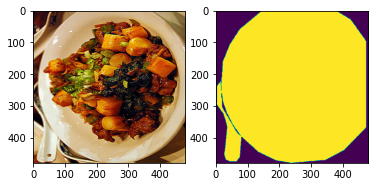

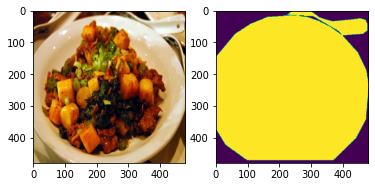

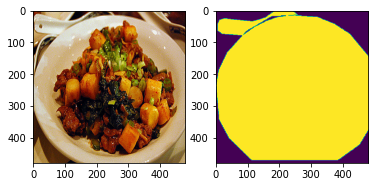

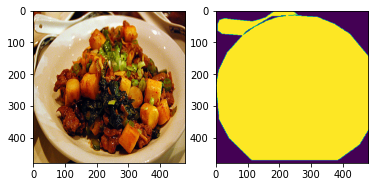

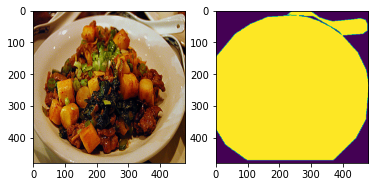

In [9]:
#Keep changing ??
for i in range(5):
  X_sample_temp, y_sample_temp = train_generator[2]
  fig, ax = plt.subplots(ncols=2)
  ax[0].imshow(X_sample_temp[4])
  ax[1].imshow(y_sample_temp[4,:,:,0])
  plt.show()

In [10]:
#Image segmentation with a U-Net Xception-style model
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
#keras.backend.clear_session()

# Build model
model = get_model((img_size,img_size), 1)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 480, 480, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
#Set aside a validation split
val_samples = 20
train_input_img= train_img[:-val_samples]
train_target_mask = train_mask[:-val_samples]
val_input_img = train_img[-val_samples:]
val_target_mask = train_mask[-val_samples:]

train_generator = DataGenerator(input_img = train_input_img, input_mask = train_target_mask, image_size = img_size,
                                augmentation=True, shuffle = False, batch_size = 5, seed = 40)
validation_generator = DataGenerator(input_img = val_input_img, input_mask = val_target_mask, image_size = img_size,
                                augmentation=True, shuffle = False, batch_size = 5, seed = 40)

In [12]:
len(train_input_img),len(train_target_mask),len(val_input_img),len(val_target_mask)

(80, 80, 20, 20)

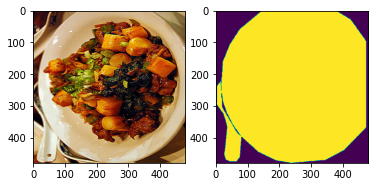

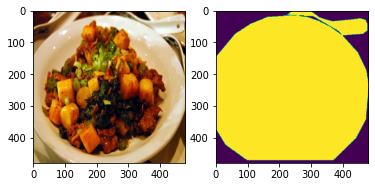

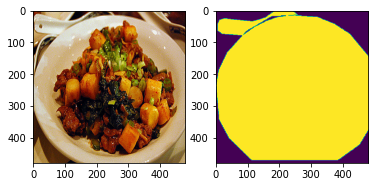

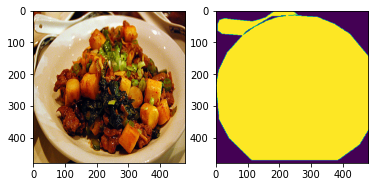

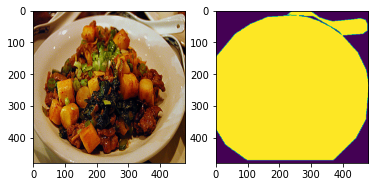

In [13]:
#Same with train generator ?? 
for i in range(5):
  X_sample_temp, y_sample_temp = validation_generator[2]
  fig, ax = plt.subplots(ncols=2)
  ax[0].imshow(X_sample_temp[4])
  ax[1].imshow(y_sample_temp[4,:,:,0])
  plt.show()

In [14]:
#Train model
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
#model.compile(optimizer="rmsprop", loss = 'binary_crossentropy')
EPOCHS = 3
model.fit(
    train_generator,
    #validation_generator,
    epochs = EPOCHS,
)

Epoch 1/3


InvalidArgumentError: ignored

In [16]:
#Train model
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.compile(optimizer="rmsprop", loss = 'binary_crossentropy')
EPOCHS = 3
model.fit(
    train_generator,
    #validation_generator,
    epochs = EPOCHS,
)

Epoch 1/3
20/20 [==============================] - 213s 10s/step - loss: 1.7747
Epoch 2/3
20/20 [==============================] - 203s 10s/step - loss: 0.5002
Epoch 3/3
20/20 [==============================] - 205s 10s/step - loss: 0.5378


In [18]:
# Generate predictions for images in the training set

train_preds = model.predict(train_generator)


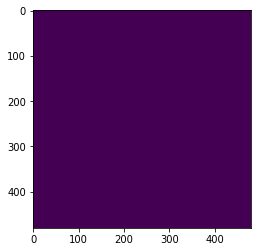

In [19]:
plt.imshow(np.squeeze(train_preds[8]))

In [20]:
from keras import backend as K
#ground_truth => mask_true
mask_true = train_mask
#train_preds => mask_preds
mask_pred = train_preds
def jaccard_coef(mask_true, mask_pred):
  mask_true_fl = K.flatten(mask_true)
  mask_pred_fl = K.flatten(mask_pred)
  #sum of multiplication of flattened ground truth masks and predicted masks (1*1=1,1*0=0,...)
  intersection = K.sum(mask_true_fl * mask_pred_fl)
  #Plus 1 to avoid being undefined
  return (intersection + 1.0)/ (K.sum(mask_true_fl) + K.sum(mask_pred_fl) - intersection + 1.0)

def jaccard_coef_loss(mask_true, mask_pred):
  return -jaccard_coef(mask_true, mask_pred) #minimize the value as loss function

In [21]:
#Train model
#model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.compile(optimizer="adam", loss = 'binary_crossentropy')
EPOCHS = 3
model.fit(
    train_generator,
    #validation_generator,
    epochs = EPOCHS,
)

Epoch 1/3
20/20 [==============================] - 218s 11s/step - loss: 0.3915
Epoch 2/3
20/20 [==============================] - 217s 11s/step - loss: 0.3316
Epoch 3/3
20/20 [==============================] - 215s 11s/step - loss: 0.3261


In [55]:
model.compile(optimizer="adam", loss = [jaccard_coef_loss], metrics = [jaccard_coef])